In [1]:
import os
import numpy as np

In [2]:
from skimage.io import imread
from skimage.color import rgb2gray

X, y = [], []
for (folder, value) in [('train/non-faces', 0), ('train/faces', 1)]:
    for file in os.listdir(folder):
        img = imread(os.path.join(folder, file))
        if len(img.shape) != 2:
            img = rgb2gray(img)
        X.append(img)
        y.append(value)
X, y = np.array(X), np.array(y)

In [3]:
from skimage.feature import hog

orientations = 9
cells_per_block = (1,1)
pixels_per_cell = (4, 4)
X = list(map(lambda im: hog(im, orientations=orientations, cells_per_block=cells_per_block,
                                pixels_per_cell=pixels_per_cell), X))

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

Данных немного, запустим поиск по сетке

In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': (0.1, 0.5, 1, 5, 10),
    'kernel': ('linear', 'rbf'),
}
clf = GridSearchCV(SVC(probability=True), param_grid=param_grid, scoring='roc_auc', n_jobs=-1)
clf.fit(X_train, y_train)
print clf.best_params_
print clf.best_score_

{'kernel': 'rbf', 'C': 10}
0.991902000198


Построим ROC-кривую и посчитаем ROC-AUC на тестовой подвыборке

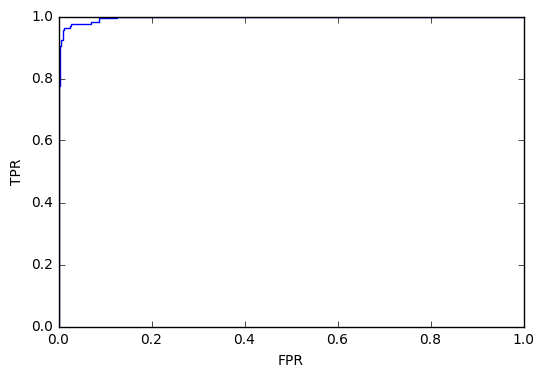

ROC-AUC=0.99598342177


In [7]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_prob = clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

print('ROC-AUC={}'.format(roc_auc_score(y_test, y_pred_prob)))

Обучим классификатор на всей выборке

In [12]:
clf = SVC(C=10, kernel='rbf', probability=True).fit(X, y)

Реализуем метод скользящего окна

In [13]:
from skimage.transform import resize

In [14]:
H, W = 32, 24  # default window's height and width

def simple_detect(img, thr, step_size, scale):
    img_h, img_w = img.shape
    face_windows = []
    for i in range(0, img_h - H, step_size):
        for j in range(0, img_w - W, step_size):
            window_repr = hog(img[i:i + H, j:j + W], orientations=orientations, cells_per_block=cells_per_block, 
                               pixels_per_cell=pixels_per_cell)
            prob = clf.predict_proba([window_repr])[0][1]
            if prob > thr:
                face_windows.append((i / scale, j / scale, H / scale, W / scale, prob))
    return face_windows
    
def detect_faces(img, thr=0.97, step_size=3):
    img_h, img_w = img.shape
    face_windows = []
    for scale in (0.8, 0.9, 1.0, 1.1, 1.3, 1.5):
        face_windows.extend(simple_detect(resize(img, (int(img_h * scale), int(img_w * scale))),
                                          thr, step_size, scale))
    return face_windows

def suppress_not_maximums(windows, overlap_thr):
    windows = np.array(windows).astype('float')
    if windows.shape[0] == 0:
        return np.array([])
    pick = []
    x1, y1 = windows[:,0], windows[:,1]
    x2, y2 = windows[:,0] + windows[:,2], windows[:,1] + windows[:,3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
    while len(idxs) > 0:
        last = idxs.shape[0] - 1
        i = idxs[last]
        pick.append(i)
 
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        h = np.maximum(0, xx2 - xx1 + 1)
        w = np.maximum(0, yy2 - yy1 + 1)
 
        overlap = (h * w) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlap_thr)[0])))
 
    return windows[pick].astype('int')

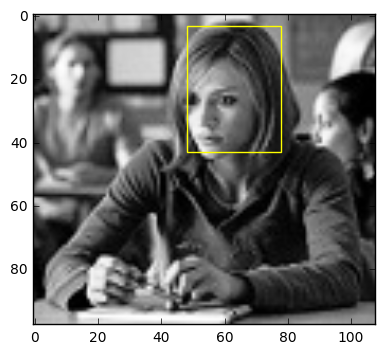

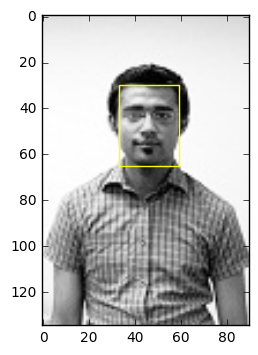

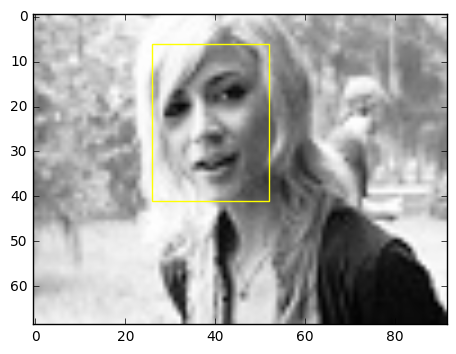

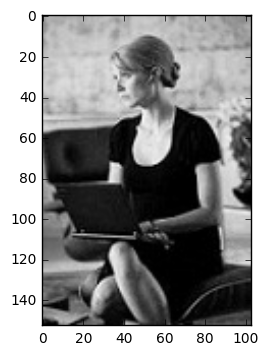

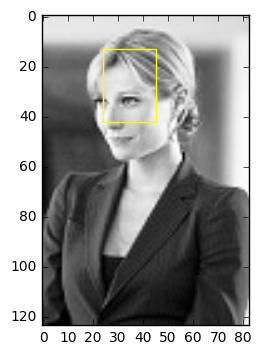

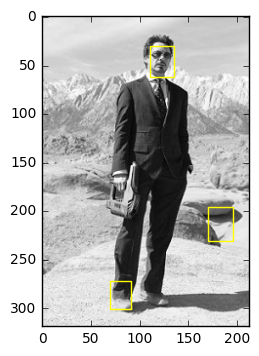

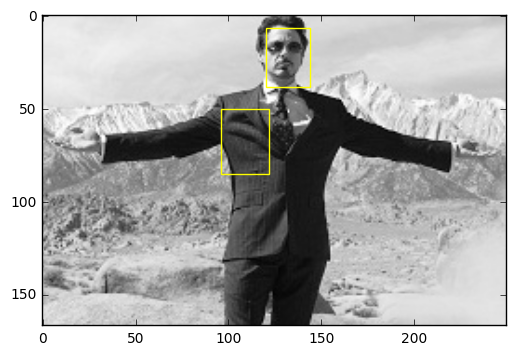

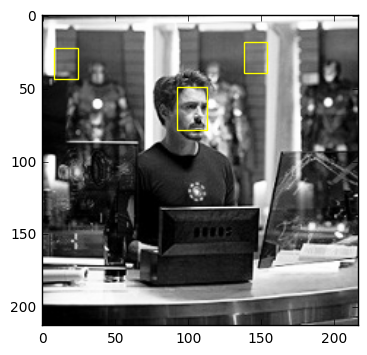

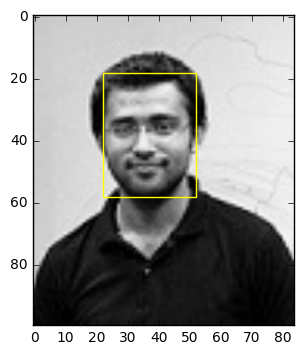

In [15]:
import matplotlib.patches as patches

def show_detection(i):
    img = rgb2gray(imread('test/{}.jpg'.format(i)))
    faces = detect_faces(img, 0.99)
    faces = suppress_not_maximums(faces, 0.25)
    ax = plt.imshow(1 - img, cmap='Greys')
    for window in faces:
        ax.axes.add_patch(patches.Rectangle((window[1], window[0]), window[3], window[2],
                                            fill=False, edgecolor='yellow'))
    plt.show()

for i in range(1, 10):
    show_detection(i)

---

Пишем истинные окна с лицами для каждой тестовой фотки

In [16]:
!mkdir face_windows_test

mkdir: cannot create directory ‘face_windows_test’: File exists


In [17]:
face_windows_test = {
    1: (45, 15, 25, 30),
    2: (33, 33, 25, 30),
    3: (27, 10, 25, 30),
    4: (33, 20, 20, 25),
    5: (20, 20, 28, 35),
    6: (105, 25, 28, 35),
    7: (115, 5, 25, 30),
    8: (90, 50, 25, 35),
    9: (23, 23, 25, 35)
}
for idx, window in face_windows_test.iteritems():
    x,y,w,h = window
    with open('face_windows_test/{}.txt'.format(idx), 'w') as f:
        f.write('0 {0} {1} {2} {3} 0 {0} {1} {2} {3} 0 0'.format(x,y,w,h))

Пишем предсказания

In [18]:
with open('prediction.txt', 'w') as f:
    for i in range(1, 10):
        img = rgb2gray(imread('test/{}.jpg'.format(i)))
        faces = detect_faces(img, 0.99)
        faces = suppress_not_maximums(faces, 0.25)
        for window in faces:
            y,x,h,w,p = window
            f.write('{};{};{};{};{};{}\n'.format(i, int(x), int(y), int(w), int(h), p))

In [19]:
!python compute-auc.py --input-base face_windows_test --detections-list prediction.txt --workdir workdir --flush-barrier 0 --good-iou 50
!rm roc.png
!python plot-detection-curve.py --output roc.png --roc-files workdir/roc.txt --titles detector

/home/ilya/projects/images-shad/labs/lab-detection/face_windows_test /home/ilya/projects/images-shad/labs/lab-detection/face_windows_test/gt /home/ilya/projects/images-shad/labs/lab-detection/face_windows_test/imgs
input base directories accessing failure
/home/ilya/.virtualenvs/images/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'PT Sans Narrow'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


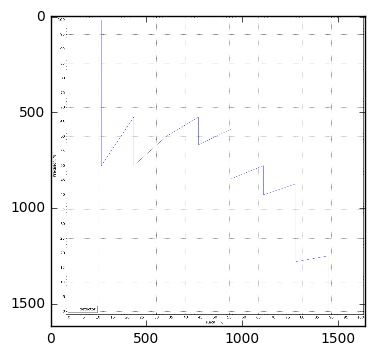

In [22]:
plt.imshow(imread('roc.png'))
plt.show()